In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pymongo
from scipy.optimize import minimize
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
data_path = Path('../../EDA/outputs/')

In [3]:
track_like_df = pd.read_csv(data_path/'track_like_expanded.csv')
track_like_df = track_like_df[['USER_ID', 'TRACK_ID']].assign(r=3)
track_like_df.columns = ['user', 'track', 'score']

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
track_download_df = pd.read_csv(data_path/'track_download_expanded.csv')
track_download_df = track_download_df[['USER_ID', 'TRACK_ID']].assign(r=1)
track_download_df.columns = ['user', 'track', 'score']

In [5]:
track_purchase_df = pd.read_csv(data_path/'track_purchase_expanded.csv')
track_purchase_df = track_purchase_df[['USER_ID','TRACK_ID']].assign(r=2)
track_purchase_df.columns = ['user','track','score']

In [6]:
track_info = pd.read_csv(data_path/'track_infov2_df.csv',index_col=0)
track_tag = pd.read_csv(data_path/'track_tag_df.csv',index_col=0)
user_info_df = pd.read_csv(data_path/'user_info.csv')
user_info_df = user_info_df.sort_values('total_interactions',ascending=False)
track_interaction_info = pd.read_csv(data_path/'track_info.csv',index_col=0)

In [7]:
track_interaction_info['total_interactions'] = track_interaction_info.noDownloads+track_interaction_info.noPurchases + track_interaction_info.noLikes
user_info_df.fillna(0,inplace=True)
user_info_df['total_interactions'] = user_info_df['noAlbum_downloads']+user_info_df['noAlbum_likes']+user_info_df['noAlbum_purchases']+user_info_df['noTrack_downloads']+user_info_df['noTrack_likes']+user_info_df['noTrack_purchases']

In [8]:
target_orch = track_tag.groupby('TYPE_KEY').get_group("ORCHESTRATION").TAG_ID.value_counts().index[:50].values
target_tag = track_tag.groupby('TYPE_KEY').get_group("GENRE").TAG_ID.value_counts().index[:35].values

In [9]:
track_tag = track_tag.loc[track_tag.TAG_ID.isin(np.concatenate([target_tag,target_orch]))]

In [10]:
user_info_df

,USER_ID,noTrack_purchases,noAlbum_purchases,noTrack_likes,noAlbum_likes,noArtist_likes,noTrack_downloads,noAlbum_downloads,total_interactions
10812,3606398,1007.0,1110.0,0.0,7.0,20.0,14642.0,1561.0,18327.0
9623,3603424,2627.0,863.0,0.0,0.0,8.0,12415.0,1626.0,17531.0
16,3568922,5.0,4.0,24.0,3827.0,2147.0,9019.0,1550.0,14429.0
5780,3593600,243.0,980.0,0.0,11.0,18.0,12388.0,1315.0,14937.0
179077,64359968,6747.0,0.0,0.0,1.0,2.0,6747.0,988.0,14483.0
...,...,...,...,...,...,...,...,...,...
277887,321749603,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
277914,321860997,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
277922,321886366,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
277924,321892524,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [57]:
sample = pd.read_csv(data_path/'total_sample.csv',index_col=0)
track_tag_sample = track_tag.loc[track_tag['TRACK_ID'].isin(sample['track'].unique())]
track_tag_sample = track_tag_sample.sort_values(by=['TRACK_ID'])
track_info_sample = track_info.loc[track_info['TRACK_ID'].isin(sample['track'].unique())]
track_info_sample = track_info_sample.sort_values(by=['TRACK_ID'])
groupby_typekey_sample=track_tag_sample.groupby(['TYPE_KEY'])
sample = sample.sort_values("track")

In [12]:
total = pd.concat([track_download_df, track_like_df, track_purchase_df])
total = total.groupby(['user', 'track']).score.sum().reset_index()
total.shape

(38402540, 3)

In [13]:
total = total.loc[total['track'].isin(track_tag['TRACK_ID'].unique())]
total = total.loc[total['track'].isin(track_info['TRACK_ID'].unique())]
total.shape

(38288211, 3)

In [14]:
min_interactions = 50
target_users = user_info_df.loc[user_info_df['total_interactions']>=min_interactions]['USER_ID'].values
target_tracks = track_interaction_info.loc[track_interaction_info['total_interactions']>=min_interactions]['TRACK_ID'].values
len(target_users),len(target_tracks)

(91880, 65704)

In [15]:
total = total.loc[total['user'].isin(target_users)]
total = total.loc[total['track'].isin(target_tracks)]
total = total.sort_values("track")
total.shape

(26279467, 3)

In [16]:
total.track.nunique(),total.user.nunique()

(65489, 91830)

In [17]:
sample.shape,sample.track.nunique(),sample.user.nunique()

((68700, 3), 1000, 85)

In [19]:
def train_valid_split(rating_df, no_users, no_items_per_user):
    gb = rating_df.groupby('user')
    test_df = pd.concat([gb.get_group(group)[:no_items_per_user] for i,group in enumerate(gb.groups) if i < no_users])
    train_df = pd.concat([rating_df,test_df]).drop_duplicates(keep=False)
    test_df =  test_df.loc[(test_df['user'].isin(train_df['user']) & (test_df['track'].isin(train_df['track'])))]
    return train_df,test_df

In [25]:
train_df,test_df = train_valid_split(sample, 50, 20)
train_df.shape,test_df.shape

((67700, 3), (1000, 3))

In [51]:
# tedad track ha va user ha dar train va total yeksan nist??
train_df['user'].nunique(),test_df['user'].nunique(),train_df['track'].nunique(),test_df['track'].nunique()

(85, 50, 1000, 42)

In [27]:
train_df = train_df.assign(user=train_df.user.astype('category'), track=train_df.track.astype('category'))
test_df = test_df.assign(user=test_df.user.astype('category'), track=test_df.track.astype('category'))

train_mat = sparse.coo_matrix((
            train_df.score.values.astype('float32'),
            (train_df.user.cat.codes.values,
             train_df.track.cat.codes.values)))

test_mat = sparse.coo_matrix((
            test_df.score.values.astype('float32'),
            (test_df.user.cat.codes.values,
             test_df.track.cat.codes.values)))

In [28]:
def feature_build(groupby_typekey,col):
    feature = groupby_typekey.get_group(col)
    le = LabelEncoder()
    feature['TAG_ID'] = le.fit_transform(feature['TAG_ID'])
    feature.drop(['TYPE_KEY'], axis = 1, inplace = True)

    feature = pd.get_dummies(feature, columns=['TAG_ID'])
    feature_cols = feature.columns.drop(['TRACK_ID'])
    feature = feature.groupby(['TRACK_ID'])[feature_cols].sum().reset_index()
    return feature

In [29]:
track_tag_total = track_tag.loc[track_tag['TRACK_ID'].isin(train_df['track'].unique())]
track_tag_total = track_tag_total.sort_values(by=['TRACK_ID'])
track_info_total = track_info.loc[track_info['TRACK_ID'].isin(train_df['track'].unique())]
track_info_total = track_info_total.sort_values(by=['TRACK_ID'])
groupby_typekey_total=track_tag_total.groupby(['TYPE_KEY'])
train_df = train_df.sort_values('track')
test_df = test_df.sort_values('track')

In [58]:
genre = feature_build(groupby_typekey_sample,'GENRE').sort_values('TRACK_ID')
orchestration = feature_build(groupby_typekey_sample,'ORCHESTRATION').sort_values('TRACK_ID')
print(genre.shape)
print(orchestration.shape)

(994, 18)
(1000, 43)


/Users/macbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/macbookpro/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [59]:
item_features = pd.merge(genre,orchestration,how='outer',on='TRACK_ID',suffixes=['_genre','_orch'])
# item_features = orchestration

In [60]:
item_features.shape

(1000, 60)

In [61]:
item_features.fillna(0,inplace=True)

In [62]:
track_info_sample.TIME_CREATED = pd.to_datetime(track_info_sample.TIME_CREATED)
track_info_sample[['year_created','month_created','day_created']] = track_info_sample["TIME_CREATED"].apply(lambda x: pd.Series([x.year,x.month,x.day]))

In [63]:
track_info_sample['duration'] = track_info_sample.C_DURATION_MIN*60+track_info_sample.C_DURATION_SEC

In [64]:
track_info_sample.drop(["TIME_CREATED","PUBLISH_DATE","C_DURATION_MIN","C_DURATION_SEC","ALBUM_ID"],axis=1,inplace=True)

In [65]:
track_info_sample.describe()

,TRACK_ID,PRICE,year_created,month_created,day_created,duration
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.581229e+08,1345.330000,2015.123000,6.169000,17.283000,272.305000
std,2.008194e+08,3028.678224,1.586943,4.020025,8.855582,240.976509
min,2.832434e+06,0.000000,2012.000000,1.000000,1.000000,55.000000
25%,6.854058e+06,0.000000,2014.000000,2.000000,9.000000,198.000000
50%,3.779853e+07,0.000000,2015.000000,6.000000,18.000000,227.000000
75%,3.478342e+08,0.000000,2016.000000,10.000000,25.000000,265.000000
max,5.553617e+08,13990.000000,2019.000000,12.000000,31.000000,2360.000000


In [66]:
item_features = pd.merge(item_features,track_info_sample,how='outer',on='TRACK_ID')
item_features.shape

(1000, 65)

In [67]:
ss = StandardScaler()
for col in item_features.columns.drop('TRACK_ID'):
    item_features[col] = ss.fit_transform(item_features[col].to_numpy().reshape(-1,1))

In [68]:
train_df.track = train_df.track.astype('int64')
train_df.user = train_df.user.astype('int64')
test_df.track = test_df.track.astype('int64')
test_df.user = test_df.user.astype('int64')

item_le = LabelEncoder()
user_le = LabelEncoder()

item_features.TRACK_ID = item_le.fit_transform(item_features.TRACK_ID)

train_df.track = item_le.transform(train_df.track)
test_df.track = item_le.transform(test_df.track)
train_df.user = user_le.fit_transform(train_df.user)
test_df.user = user_le.transform(test_df.user)

In [69]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''
    c = 0
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        if n_rel == 0:
            c += 1
            continue

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel
        
#         print(n_rel,n_rec_k,n_rel_and_rec_k)
        
    print(c)

    return precisions, recalls



In [70]:
# # train,valid = train_valid_split(sample,50,10)
# train = sample.pivot_table('score','user','track',dropna=False,fill_value=0)

In [100]:
train = train_df.pivot_table('score','user','track',dropna=False,fill_value=0)
# valid = valid.pivot_table('score','user','track',dropna=False,fill_value=0)

In [72]:
# train.shape,valid.shape

In [73]:
def convert_sparse_matrix_to_sparse_tensor(X):
    indices = np.mat([X.row, X.col]).transpose()
    return tf.SparseTensor(indices, X.data, X.shape)

In [74]:
train_tf_sparse = convert_sparse_matrix_to_sparse_tensor(train_mat)
test_tf_sparse = convert_sparse_matrix_to_sparse_tensor(test_mat)

In [94]:
class MatrixFactorization(tf.keras.layers.Layer):
    def __init__(self, emb_sz,Mnp, **kwargs):
        super(MatrixFactorization, self).__init__(**kwargs)
        self.emb_sz = emb_sz
        self.Mnp = Mnp

    def build(self, input_shape):
        num_users, num_tracks = input_shape
        
        self.U = self.add_variable("U", 
            shape=[num_users, self.emb_sz], 
            dtype=tf.float32,
            initializer=tf.initializers.GlorotUniform)
    
        self.M = tf.Variable(initial_value=self.Mnp,trainable=False,name='M',dtype=tf.float32)
        
        self.bu = self.add_variable("bu",
            shape=[num_users],
            dtype=tf.float32, 
            initializer=tf.initializers.Ones)
        
        self.bm = self.add_variable("bm",
            shape=[num_tracks],
            dtype=tf.float32, 
            initializer=tf.initializers.Ones)
        
        self.bg = self.add_variable("bg", 
            shape=[],
            dtype=tf.float32,
            initializer=tf.initializers.Ones)

    def call(self,input):
        out = tf.matmul(self.U,tf.transpose(self.M))
        out = tf.add(out,tf.expand_dims(self.bu, axis=1))
        out = tf.add(out,tf.expand_dims(self.bm, axis=0))
        out = out + self.bg
        return out


class MatrixFactorizer(tf.keras.Model):
    def __init__(self, embedding_size,Mnp):
        super(MatrixFactorizer, self).__init__()
        self.matrixFactorization = MatrixFactorization(embedding_size,Mnp)
        self.sigmoid = tf.keras.layers.Activation("sigmoid")

    def call(self, input):
        output = self.matrixFactorization(input)
        output = self.sigmoid(output) * (6-0+1) + 0-0.5
        return output


def loss_fn(source, target):
    mse = tf.keras.losses.MeanSquaredError()
    loss = mse(source, target)
    return loss


Model: "matrix_factorizer_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
matrix_factorization_23 (Mat multiple                  70526     
_________________________________________________________________
activation_23 (Activation)   multiple                  0         
Total params: 70,526
Trainable params: 6,526
Non-trainable params: 64,000
_________________________________________________________________
None
step: 0, loss: 20.682
step: 1000, loss: 5.618
step: 2000, loss: 4.422
step: 3000, loss: 3.737
step: 4000, loss: 3.277
step: 5000, loss: 2.965
step: 6000, loss: 2.761
step: 7000, loss: 2.512
step: 8000, loss: 2.386
step: 9000, loss: 2.238


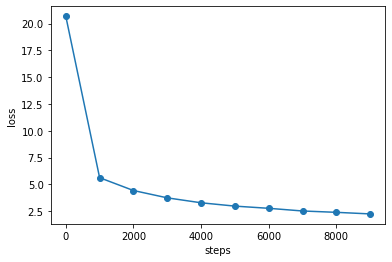

In [111]:
EMBEDDING_SIZE = item_features.shape[1] - 1
num_users = train_df.user.nunique()
num_tracks = train_df.track.nunique()

model = MatrixFactorizer(EMBEDDING_SIZE,item_features.drop('TRACK_ID',axis=1).to_numpy())
model.build(input_shape=(num_users,num_tracks))
print(model.summary())

optimizer = tf.optimizers.Adam()

losses, steps = [], []
for i in range(10000):
    with tf.GradientTape() as tape:
        Xhat = model(inputs=None)
#         loss between sparse and dense?
        loss = loss_fn(train.to_numpy(),Xhat)
        if i % 1000 == 0:
            loss_value = loss.numpy()
            losses.append(loss_value)
            steps.append(i)
            print("step: {:d}, loss: {:.3f}".format(i, loss_value))
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

# plot training loss
plt.plot(steps, losses, marker="o")
plt.xlabel("steps")
plt.ylabel("loss")
plt.show()

In [112]:
preds = model(inputs=None)
r2_score(train.to_numpy(),preds)

-0.22862307038385193